In [1]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from transformers_interpret import ImageClassificationExplainer
from PIL import Image
import requests

/Users/charlespierse/Library/Caches/pypoetry/virtualenvs/transformers-interpret-gSMYfsmB-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Initialise an image classification explainer
Initialising an image classification is very simple, all you need a is a image classification model finetuned or trained to work with Huggingface and its feature extractor. 

In [2]:
model_name = "google/vit-base-patch16-224"

In [46]:
model = AutoModelForImageClassification.from_pretrained(model_name)
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

In [47]:
image_link = "https://imagesvc.meredithcorp.io/v3/mm/image?url=https%3A%2F%2Fstatic.onecms.io%2Fwp-content%2Fuploads%2Fsites%2F47%2F2020%2F08%2F16%2Fgolden-retriever-177213599-2000.jpg"

In [48]:
image = Image.open(requests.get(image_link, stream=True).raw)

In [49]:
image_classification_explainer = ImageClassificationExplainer(model=model, feature_extractor=feature_extractor)

In [50]:
image_attributions = image_classification_explainer(
    image
)

In [8]:
image_attributions.shape

torch.Size([1, 3, 224, 224])

## Visualizing Attributions
Attrbutions can be easily visualized using the `visualize` method of the explainer. There are currently 4 supported visualization methods. 
- `heatmap` - a heatmap of positive and negative attributions is drawn in using the dimensions of the image. 
- `overlay` - the heatmap is overlayed over a grayscaled version of the original image
- `masked_image` - the absolute value of attrbutions is used to create a mask over original image
- `alpha_scaling` - Sets alpha channel (transparency) of each pixel to be equal to normalized attribution value.

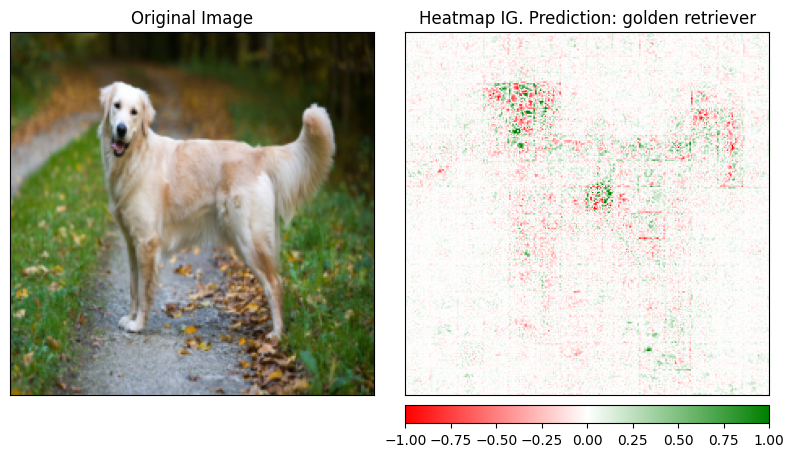

(<Figure size 800x600 with 4 Axes>,
 array([<AxesSubplot:title={'center':'Original Image'}>,
        <AxesSubplot:title={'center':'Heatmap IG. Prediction: golden retriever'}>],
       dtype=object))

In [51]:
image_classification_explainer.visualize(
    method="heatmap",
    side_by_side=True,
    outlier_threshold=0.03
    
)

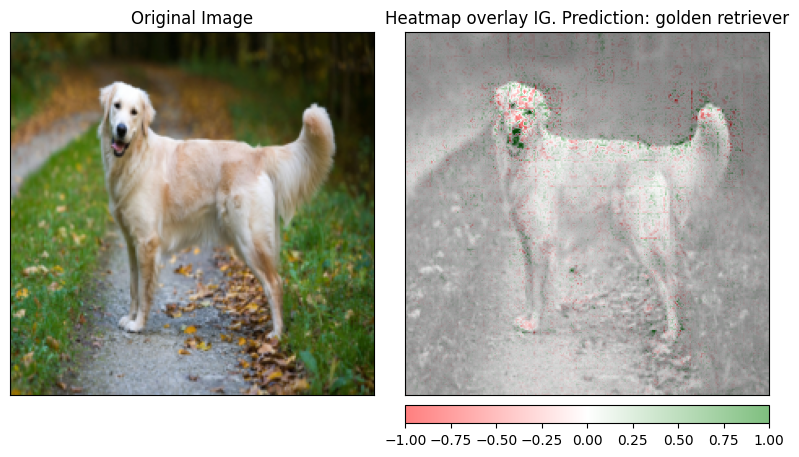

(<Figure size 800x600 with 4 Axes>,
 array([<AxesSubplot:title={'center':'Original Image'}>,
        <AxesSubplot:title={'center':'Heatmap overlay IG. Prediction: golden retriever'}>],
       dtype=object))

In [41]:
image_classification_explainer.visualize(
    method="overlay",
    side_by_side=True,
    outlier_threshold=0.03
    
)

In [43]:
image_classification_explainer.visualize(
    method="masked_image",
    side_by_side=True,
    outlier_threshold=0.03
    
)

(<Figure size 800x600 with 4 Axes>,
 array([<AxesSubplot:title={'center':'Original Image'}>,
        <AxesSubplot:title={'center':'Masked Image IG. Prediction: golden retriever'}>],
       dtype=object))

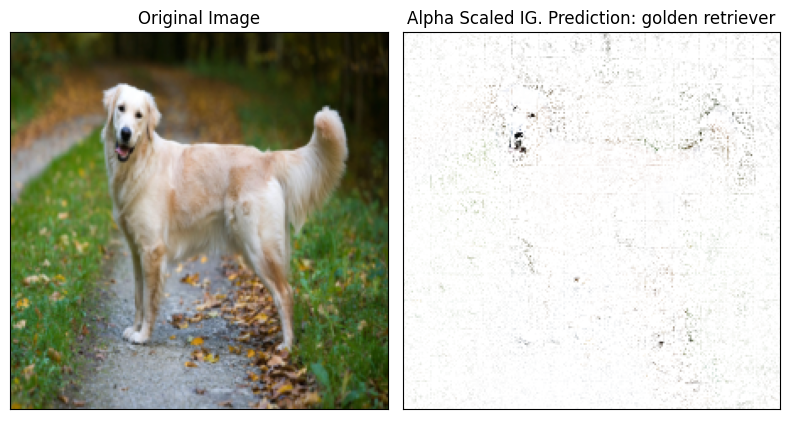

(<Figure size 800x600 with 4 Axes>,
 array([<AxesSubplot:title={'center':'Original Image'}>,
        <AxesSubplot:title={'center':'Alpha Scaled IG. Prediction: golden retriever'}>],
       dtype=object))

In [45]:
image_classification_explainer.visualize(
    method="alpha_scaling",
    side_by_side=True,
    outlier_threshold=0.03
    
)

### Outlier Threshold
The `outlier_threshold` as defined in the Captum docs is <blockquote> Top attribution values which
                    correspond to a total of outlier_perc percentage of the
                    total attribution... </blockquote>
Another way to think of this is that we select only the `outlier_threshold` percentage of attributions to be visualised for given a visualization. The higher the percentage the more noise we will see in the visualisation and it will be harder to differentiate attributions. It is best to start with low values (< 0.1) and work your way up when experimenting. 

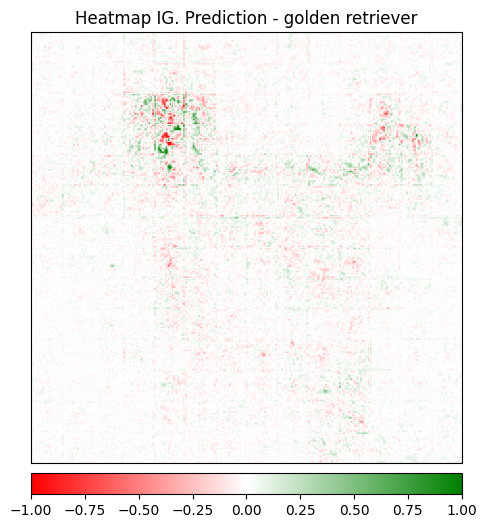

(<Figure size 600x600 with 2 Axes>,
 <AxesSubplot:title={'center':'Heatmap IG. Prediction - golden retriever'}>)

In [13]:
image_classification_explainer.visualize(
    method="heatmap",
    outlier_threshold=0.01
    
)

In [14]:
image_classification_explainer.visualize(
    method="heatmap",
    outlier_threshold=0.2
    
)

(<Figure size 600x600 with 2 Axes>,
 <AxesSubplot:title={'center':'Heatmap IG. Prediction - golden retriever'}>)

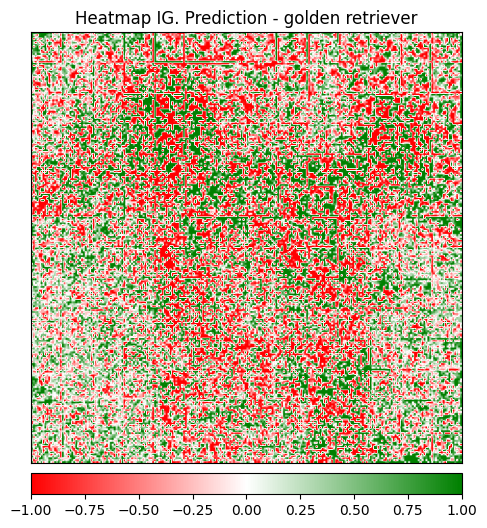

(<Figure size 600x600 with 2 Axes>,
 <AxesSubplot:title={'center':'Heatmap IG. Prediction - golden retriever'}>)

In [15]:
image_classification_explainer.visualize(
    method="heatmap",
    outlier_threshold=0.8
    
)

## Saving attribution images
Images are easily saved. Simply pass a path to the explainers `visualize` method.

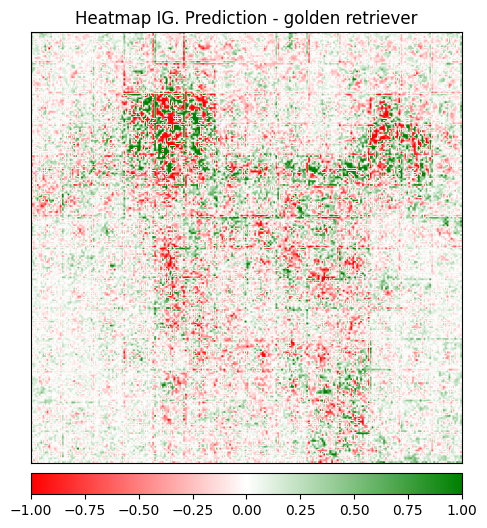

(<Figure size 600x600 with 2 Axes>,
 <AxesSubplot:title={'center':'Heatmap IG. Prediction - golden retriever'}>)

In [16]:
image_classification_explainer.visualize(
    save_path="./explainer_image.png",
    method="heatmap",
    outlier_threshold=0.2
    
)

## Advanced Features

#### Forcing attributions for a particular class name or index
If you are interested in looking at attributions for a particular output class regardless of whether or not it is the predicted class this can be easily achieved with the image classification explainer. 

In [29]:
# attributions for a particular class index
image_attributions = image_classification_explainer(
    image,
    index=100
)

In [30]:
image_classification_explainer.visualize()

(<Figure size 600x600 with 2 Axes>,
 <AxesSubplot:title={'center':'Heatmap Overlay IG. Prediction - golden retriever'}>)

In [31]:
# attributions for a particular class name
image_attributions = image_classification_explainer(
    image,
    class_name="Irish terrier"
)

In [32]:
image_classification_explainer.visualize()

(<Figure size 600x600 with 2 Axes>,
 <AxesSubplot:title={'center':'Heatmap Overlay IG. Prediction - golden retriever'}>)

## Using raw integrated gradients without noise tunnel
By default the image classification explainer will apply [noise tunnel](https://captum.ai/api/noise_tunnel.html) smoothing to the attributions, noise tunnel is an additional approximation applied on top of the integrated gradients via the addition of gaussian noise to samples that <blockquote>  [approximates smoothing the given attribution method with a Gaussian Kernel](https://captum.ai/api/noise_tunnel.html) </blockquote>

However, if you would rather see only the true non-smoothed integrated gradients, this can be done by explicitly passing the `attribution_type` as `"IG"` when instantiating the class. 


In [33]:
image_classification_explainer = ImageClassificationExplainer(model=model, feature_extractor=feature_extractor, attribution_type="IG")

In [34]:
image_attributions = image_classification_explainer(
    image
)

In [35]:
image_classification_explainer.visualize()

(<Figure size 600x600 with 2 Axes>,
 <AxesSubplot:title={'center':'Heatmap Overlay IG. Prediction - golden retriever'}>)